In [ ]:
#Training model
##Mount drive to get access to data
##Create directory to store training data just as in the analyzedata.ipynb
##Set configuration for notebook so its reproducible
##Create Dataset and dataloaders

##Build Model with selected backbone
##Create training loop
##Create checkpoints to save model in directory

In [ ]:
!pip install segmentation-models-pytorch
!pip install timm
!pip install --upgrade albumentations
!pip install opencv-python-headless==4.1.2.30
!pip install torchsummary


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 88 kB 3.0 MB/s 
     |████████████████████████████████| 376 kB 10.1 MB/s 
     |████████████████████████████████| 58 kB 6.4 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12421 sha256=31e168afcf371f36683f4407b914f2e03c522214c43ef7f9dac3b6be259d08f8
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=c96c78fc9d80dd8098e2c4999245088eb983e2c44b21ed987900180fc0cd2fb7
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in in

In [ ]:
from torch.utils.data import Dataset, DataLoader
import matplotlib.image as pltimg
import albumentations as A
import segmentation_models_pytorch as smp
import numpy as np
import torch
import gc

# **Preparing DataSet**

Mounting gdrive to access data files

In [ ]:
!pwd

/content


In [ ]:
#Making directory
import os

#data_path
path = "rseg_data"
if (os.path.isdir(path)):
  print("Path Already exists")
else:
  os.mkdir(path)

In [ ]:
from google.colab import drive
drive_path = "drive"
if (os.path.isdir(drive_path)):
  print("Drive path Created")

else:
  os.mkdir(drive_path)

drive.mount(drive_path)

Mounted at drive


In [ ]:
##Unzipping data into data directory
import zipfile
file_path = "drive/MyDrive/Road_segm/data_road.zip"
with zipfile.ZipFile(file_path,'r') as zip_p:
  zip_p.extractall(path)

In [ ]:
##Copying csv to data directory
import shutil

src = "drive/MyDrive/Road_segm/road_segm.csv"
dst = path

shutil.copy(src,dst)

'rseg_data/road_segm.csv'

In [ ]:
import pandas as pd

df =pd.read_csv(path +"/road_segm.csv")
df.head()

,ID,CLASS,IMG_PTH,GT_IMG_PTH
0,0,0,rseg_data/data_road/training/image_2/um_000000...,rseg_data/data_road/training/gt_image_2/um_roa...
1,1,0,rseg_data/data_road/training/image_2/um_000001...,rseg_data/data_road/training/gt_image_2/um_roa...
2,2,0,rseg_data/data_road/training/image_2/um_000002...,rseg_data/data_road/training/gt_image_2/um_roa...
3,3,0,rseg_data/data_road/training/image_2/um_000003...,rseg_data/data_road/training/gt_image_2/um_roa...
4,4,0,rseg_data/data_road/training/image_2/um_000004...,rseg_data/data_road/training/gt_image_2/um_roa...


**SMP Image Segmentation Pytorch for U-Net Model
https://github.com/chsasank/segmentation_models.pytorch**

In [ ]:
#SMP model can be loaded and used
#Build augmentation functions, preprocessing functions for the ENCODER you
#intend to use
#Build aug and pp functions, create data loaders for train and val
##Build model and identify what it needs as input.
#Also set loss functions using dice and set your optimizing functions.
##Build training loop

In [ ]:
def display(image):
  plt.figure(figsize=(10,10))
  plt.axis('off')
  plt.imshow(image)

In [ ]:
IMAGE_SIZE = 256

In [ ]:
def train_augmentation():
  transform = A.Compose([
                           A.Resize(width=IMAGE_SIZE,height=IMAGE_SIZE),
                           A.HorizontalFlip(p=0.5),
                           A.ShiftScaleRotate(scale_limit=0.5,rotate_limit=0,shift_limit=0.1),
                           A.OneOf([
                                    A.RandomBrightnessContrast(p=1),
                                    A.RandomGamma(p=1)
                                    ],
                                   p=0.9),
                           A.OneOf([
                                    A.Sharpen(p=1),
                                    A.Blur(blur_limit=3,p=1),
                                    A.MotionBlur(blur_limit=3,p=1)],
                                   p=0.9)
    ])
  return transform


def val_augmentation():
  transform = A.Compose([A.Resize(width=IMAGE_SIZE,height=IMAGE_SIZE)])

  return transform
    

In [ ]:
def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')

  
def preprocessing(pp_func):
  transform = A.Compose([
                         A.Lambda(image = pp_func),
                         A.Lambda(image=to_tensor,mask=to_tensor)
  ])

  return transform

In [ ]:
import cv2

In [ ]:
#Creating pytorch dataset
#Receives a csv file and accesses images and labels or ground truth via pathas

class SegDataset(Dataset):
  def __init__(self,df,train = True,augmentation=None,transform=None):
    super(SegDataset,self).__init__

    self.df = df
    self.train = train
    self.transform = transform
    self.augmentation = augmentation

  def __len__(self):
    return self.df.shape[0]


  def __getitem__(self,index):
    img_path = df.iloc[index,2] # Index 2 is the image path
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


    #Ground Truth Image
    gt_img_path = df.iloc[index,3] #Index 3 is the gt image path
    gt_img = cv2.imread(gt_img_path)
    gt_img = cv2.cvtColor(gt_img, cv2.COLOR_BGR2RGB)
    label = df.iloc[index,1]

    #Applying Image Augmentations
    if self.augmentation:
      data = self.augmentation(image=image,mask=gt_img)
      image,gt_img = data["image"],data["mask"]
      #gt_img = self.augmentation(gt_img)

    #Applying Transforms to Image based on Backbone used in Encoder
    if self.transform:
      data = self.transform(image=image,mask=gt_img)
      image,gt_img = data["image"],data["mask"]
      #gt_img = self.transform(gt_img)

    data = {"Image":image,
            "GT_Image":gt_img,
            "Label":label}

    return image,gt_img


In [ ]:
import torch

ENCODER = "efficientnet-b5"
ENCODER_WEIGHTS = "imagenet"
CLASSES = ['road','lane']
ACTIVATION = 'softmax2d'
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
pre_processingfn = smp.encoders.get_preprocessing_fn(ENCODER,ENCODER_WEIGHTS)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
data = next(iter(SegDataset(df.iloc[:5,:],augmentation=val_augmentation(),transform=preprocessing(pre_processingfn))))

In [ ]:
len(data)

2

In [ ]:
data[0].shape

(3, 256, 256)

In [ ]:
data[1].shape

(3, 256, 256)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


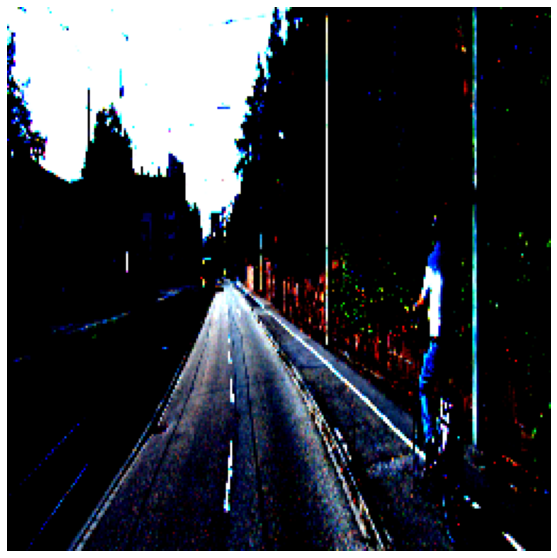

In [ ]:
display(data[0].transpose((1,2,0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


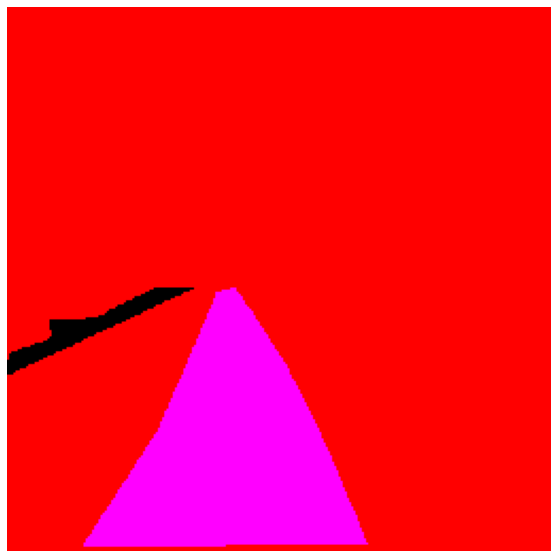

In [ ]:
display(data[1].transpose((1,2,0)))

In [ ]:
print(f"{data[0].shape}, {data[1].shape}")

(3, 256, 256), (3, 256, 256)


# **SMP Model Training**

**This notebook will be using the U-NET Architecture with EfficientNetV2**

In [ ]:
ENCODER = 'se_resnext50_32x4d'
ENCODER_WEIGHTS = "imagenet"
CLASSES = ['road','lane','background']
ACTIVATION = 'softmax2d'
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(DEVICE)

cuda


In [ ]:
##Segmentation model
model = smp.Unet(
    encoder_name=ENCODER,
    encoder_weights = ENCODER_WEIGHTS,
    classes = len(CLASSES),
    activation = ACTIVATION
)

pre_processingfn = smp.encoders.get_preprocessing_fn(ENCODER,ENCODER_WEIGHTS)

Downloading: "http://data.lip6.fr/cadene/pretrainedmodels/se_resnext50_32x4d-a260b3a4.pth" to /root/.cache/torch/hub/checkpoints/se_resnext50_32x4d-a260b3a4.pth


  0%|          | 0.00/105M [00:00<?, ?B/s]

In [ ]:
#from torchsummary import summary

#summary(model,input_size=(3,256,256).to(DEVICE))

**Train And Validation Data Loaders Function**

In [ ]:
##Function which creates and returns training and validation dataloaders
##Pass in dataframe object, so function randomly creates a train and test split
def train_val_dataloader(df,batch,val_batch):

  #Train and val indexes
  #0.7 0.3 split on dataframe
  train_idx = list(df.sample(frac=0.7).index)
  val_idx = list(df.loc[df.index.difference(train_idx)].index)

  #Train and val dfs
  train_df = df.iloc[train_idx]
  val_df = df.iloc[val_idx]
    
  #Train and val datasets
  train_ds = SegDataset(train_df,augmentation = train_augmentation(),transform=preprocessing(pre_processingfn))
  val_ds = SegDataset(val_df,augmentation = val_augmentation(),transform=preprocessing(pre_processingfn))
    
  #Train and val dataloaders
  train_dl = DataLoader(train_ds,batch_size = batch)
  val_dl = DataLoader(val_ds,batch_size = val_batch)
    
  return train_dl,val_dl

In [ ]:
##Loss
loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

In [ ]:
print(loss)

DiceLoss(
  (activation): Activation(
    (activation): Identity()
  )
)


In [ ]:
# create epoch runners 
# it is a simple loop of iterating over dataloader`s samples
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

**Training**

In [ ]:
#training loop
#One epoch
def train_epoch():
  for batch in train_loader:
    model.train()
    image,gtimage = batch
    image.to(DEVICE)
    gtimage.to(DEVICE)

    optimizer.zero_grad()

    #forward pass
    out = model(image)

    #loss
    error = loss(out,gtimage)

    #backprop
    error.backward()

    optimizer.step()


In [ ]:
#train_loader,valid_loader = train_val_dataloader(df,20,1)

In [ ]:
#datal = next(iter(train_loader))

In [ ]:
  #img,gt = datal
  #out = model(img)
  #print(out.shape)
  #print(gt.shape)

In [ ]:
# train model for 50 epochs

max_score = 0
train_loader,valid_loader = train_val_dataloader(df,30,10)

for i in range(0, 50):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save({'state_dict': model.state_dict(),'optimizer' :optimizer.state_dict()}, 'drive/MyDrive/Road_segm/best_model.pth')
        print('Model saved!')
        
    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
train:   0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


valid: 100%|██████████| 9/9 [00:02<00:00,  3.68it/s, dice_loss - 0.3512, iou_score - 0.2996]
Model saved!

Epoch: 1
valid: 100%|██████████| 9/9 [00:02<00:00,  3.27it/s, dice_loss - 0.2467, iou_score - 0.3637]
Model saved!

Epoch: 2
valid: 100%|██████████| 9/9 [00:02<00:00,  3.31it/s, dice_loss - 0.1573, iou_score - 0.4723]
Model saved!

Epoch: 3
valid: 100%|██████████| 9/9 [00:02<00:00,  3.22it/s, dice_loss - 0.09369, iou_score - 0.8164]
Model saved!

Epoch: 4
valid: 100%|██████████| 9/9 [00:02<00:00,  3.23it/s, dice_loss - 0.02867, iou_score - 1.21]
Model saved!

Epoch: 5
valid: 100%|██████████| 9/9 [00:02<00:00,  3.32it/s, dice_loss - -0.02641, iou_score - 1.475]
Model saved!

Epoch: 6
valid: 100%|██████████| 9/9 [00:02<00:00,  3.32it/s, dice_loss - -0.0757, iou_score - 1.748]
Model saved!

Epoch: 7
valid: 100%|██████████| 9/9 [00:02<00:00,  3.24it/s, dice_loss - -0.1012, iou_score - 1.936]
Model saved!

Epoch: 8
valid: 100%|██████████| 9/9 [00:02<00:00,  3.19it/s, dice_loss - -0.111

Training Loop

In [ ]:
datal = next(iter(valid_loader))

img,gt = datal
out = model(img.to(DEVICE))
print(out.shape)
print(gt.shape)

torch.Size([10, 3, 256, 256])
torch.Size([10, 3, 256, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


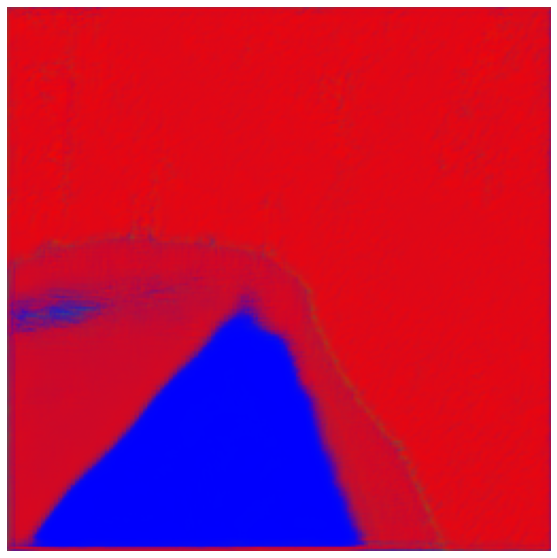

In [ ]:
display(out.cpu().detach().numpy()[8].transpose(1,2,0))

In [ ]:
img[8].shape

torch.Size([3, 256, 256])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


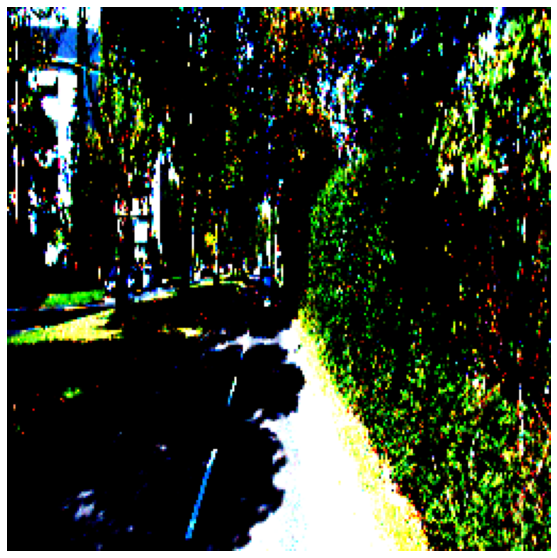

In [ ]:
display(img[8].permute(1,2,0))

**Erasing Out every red pixel**

In [ ]:
test_img = out.cpu().detach().numpy()[8].transpose(1,2,0)

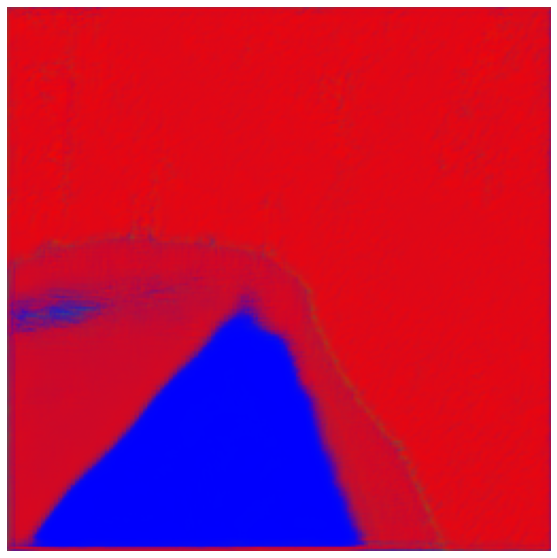

In [ ]:
display(test_img)

In [ ]:
test_img

array([[[0.5761655 , 0.18980454, 0.23402998],
        [0.5803815 , 0.12356984, 0.29604864],
        [0.6209317 , 0.13640621, 0.24266207],
        ...,
        [0.67306954, 0.11942121, 0.20750919],
        [0.68083614, 0.12830272, 0.19086109],
        [0.6758071 , 0.09562243, 0.22857043]],

       [[0.65721375, 0.14033692, 0.20244932],
        [0.7599872 , 0.05175177, 0.18826102],
        [0.76411927, 0.05622683, 0.17965396],
        ...,
        [0.87159836, 0.02977252, 0.09862902],
        [0.8133289 , 0.04556547, 0.14110549],
        [0.6323209 , 0.07070872, 0.2969703 ]],

       [[0.65959084, 0.14613324, 0.1942759 ],
        [0.7361313 , 0.07863835, 0.18523027],
        [0.84640896, 0.04007211, 0.11351881],
        ...,
        [0.8378422 , 0.03373586, 0.12842186],
        [0.72788393, 0.05573149, 0.2163846 ],
        [0.551511  , 0.0847167 , 0.36377236]],

       ...,

       [[0.51916885, 0.16422988, 0.31660128],
        [0.5851941 , 0.05182708, 0.36297882],
        [0.5032309 , 0